In [1]:
#initializing workspace
import pandas as pd
import matplotlib.pyplot as plt
import trxtools as tt
import os
from pyCRAC.Parsers import GTF2
import pyBigWig
import numpy as np
from trxtools.BigWig import *
from scipy.signal import argrelextrema

pathTAB = "../seq_references/Saccharomyces_cerevisiae.EF4.74.dna.toplevel.shortChrNames.tab"
pathGTF = "../seq_references/Saccharomyces_cerevisiae.EF4.74.shortChNames_with_PolIII_transcripts_extended_slop_intergenic_sort.gtf"
gtf = GTF2.Parse_GTF()
gtf.read_GTF(pathGTF)
gtf.read_TAB(pathTAB)

sequences = pd.read_csv(pathTAB, sep='\t',names=['chr','sequence'],index_col=0)
chr_len = sequences['sequence'].str.len()

pathDir = "../04_BigWig/"
pathMeta = "../06_metadata/"

dinucleotides = pd.read_csv(pathMeta+'/properties_of_dinucleotides.csv', index_col=0)
dinucleotides.index = dinucleotides.reset_index().index.astype(str)+"_"+dinucleotides.index

cleavage_sites = {"5' end" : (300),
                   'A0' : (300+609),
                   'A1' : (300+700),
                   'D'  : (300+2500),
                   'A2' : (300+2712),
                   'A3' : (300+2784),
                   'B1L': (300+2855),
                   'B1S': (300+2861),
                   'E'  : (300+3019),
                   'C1' : (300+3251),
                   'B2' : (300+6647),
                   'B0-1' : (300+6661),
                   'B0-2' : (300+6697),
                   'T1' : (300+6739)}

print(gtf.strand("RDN37-1"), gtf.chromosome("RDN37-1"), gtf.chromosomeCoordinates("RDN37-1"))
print(gtf.strand("RDN37-2"), gtf.chromosome("RDN37-2"), gtf.chromosomeCoordinates("RDN37-2"))

- chrXII (451785, 457732)
- chrXII (460922, 466869)


In [2]:
flank = 1000

seq1_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][451785-flank:457732+flank])
seq2_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][460922-flank:466869+flank])

#loading datasets

data_files_raw = [f for f in os.listdir(pathDir) if 'raw' in f and "bw" in f]
data_files_5end = [f for f in os.listdir(pathDir) if 'PROFILE_5end' in f and "bw" in f]
data_files_3end = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" not in f and "bw" in f]
data_files_polyA = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" in f and "bw" in f]

print(len(os.listdir(pathDir)))
print(len(data_files_raw))
print(len(data_files_5end))
print(len(data_files_3end))
print(len(data_files_polyA))

df01a_RDN371_datasets_3end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
s1_RDN371_sequence = df01a_RDN371_datasets_3end['nucleotide'] #kee[ for future use
df01b_RDN372_datasets_3end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
df01_RDN37_3end = df01a_RDN371_datasets_3end.drop('nucleotide',axis='columns') + df01b_RDN372_datasets_3end.drop('nucleotide',axis='columns')

df02a_RDN371_datasets_5end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df02b_RDN372_datasets_5end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df02_RDN37_5end = df02a_RDN371_datasets_5end.drop('nucleotide',axis='columns') + df02b_RDN372_datasets_5end.drop('nucleotide',axis='columns')

df03a_RDN371_datasets_polyA = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03b_RDN372_datasets_polyA = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03_RDN37_polyA = df03a_RDN371_datasets_polyA.drop('nucleotide',axis='columns') + df03b_RDN372_datasets_polyA.drop('nucleotide',axis='columns')

df04a_RDN371_datasets_raw = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04b_RDN372_datasets_raw = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04_RDN37_raw = df04a_RDN371_datasets_raw.drop('nucleotide',axis='columns') + df04b_RDN372_datasets_raw.drop('nucleotide',axis='columns')

df05_folding = foldingFromBigWig("RDN37-1",data_path=pathMeta,data_files=["w65_dG"], gtf=gtf,ranges=flank,range5end=700)

560
112
112
112
112


/home/tturowski/TurowskiLab/trxtools/trxtools/BigWig.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1[name][0:ranges-range5end+int(name.replace("w","").replace("_dG",""))] = np.nan #remove folding for the 5'end


# Fig 6 A-D Rat1 and Mtr4

In [3]:
df11_Rpa190_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP'], 
                                     let_out=['hmo1','0s','25rDNA','UVA'],stats=True)

df13_Rat1_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Rat1'],stats=True)

df14_Rat1_5end = tt.profiles.preprocess(df02_RDN37_5end,
                                     let_in=['Rat1'],stats=True)

# df15_Rat1_3end = tt.profiles.preprocess(df01_RDN37_3end,
#                                      let_in=['Rat1'],stats=True)

df16_Rat1_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Rat1'],stats=True)

df17_Mtr4_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Mtr4','wt'],stats=True)

# df18_Mtr4_5end = tt.profiles.preprocess(df02_RDN37_5end,
#                                      let_in=['Mtr4','wt'],stats=True)

df19_Mtr4_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Mtr4','wt'],stats=True)

df20_Mtr4_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Mtr4','wt'],stats=True)

df21_Mtr4Rrp44exo_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)

df22_Mtr4Rrp44exo_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)

df23_Mtr4Rrp44exo_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)

/home/tturowski/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Experiments: 
['XX000000_Rpa190HTP_wt_none_2_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_5_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_1_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_4_PROFILE_3end']
Experiments: 
['SG120826_Rat1HTP_wt_none_11_default_raw', 'SG120826_Rat1HTP_wt_none_5_default_raw']
Experiments: 
['SG120826_Rat1HTP_wt_none_5_default_PROFILE_5end', 'SG120826_Rat1HTP_wt_none_11_default_PROFILE_5end']
Experiments: 
['SG120826_Rat1HTP_wt_none_11_default_PROFILE_3end_polyA', 'SG120826_Rat1HTP_wt_none_5_default_PROFILE_3end_polyA']
Experiments: 
['CDF000001_Mtr4HTP_wt_none_1_raw', 'CDF000002_Mtr4HTP_wt_none_2_raw']
Experiments: 
['CDF000002_Mtr4HTP_wt_none_2_PROFILE_3end', 'CDF000001_Mtr4HTP_wt_none_1_PROFILE_3end']
Experiments: 
['CDF000001_Mtr4HTP_wt_none_1_PROFILE_3end_polyA', 'CDF000002_Mtr4HTP_wt_none_2_PROFILE_3end_polyA']
Experiments: 
['CDF000001_Mtr4HTP_Rrp44-exo_none_1_PROFILE_3end'

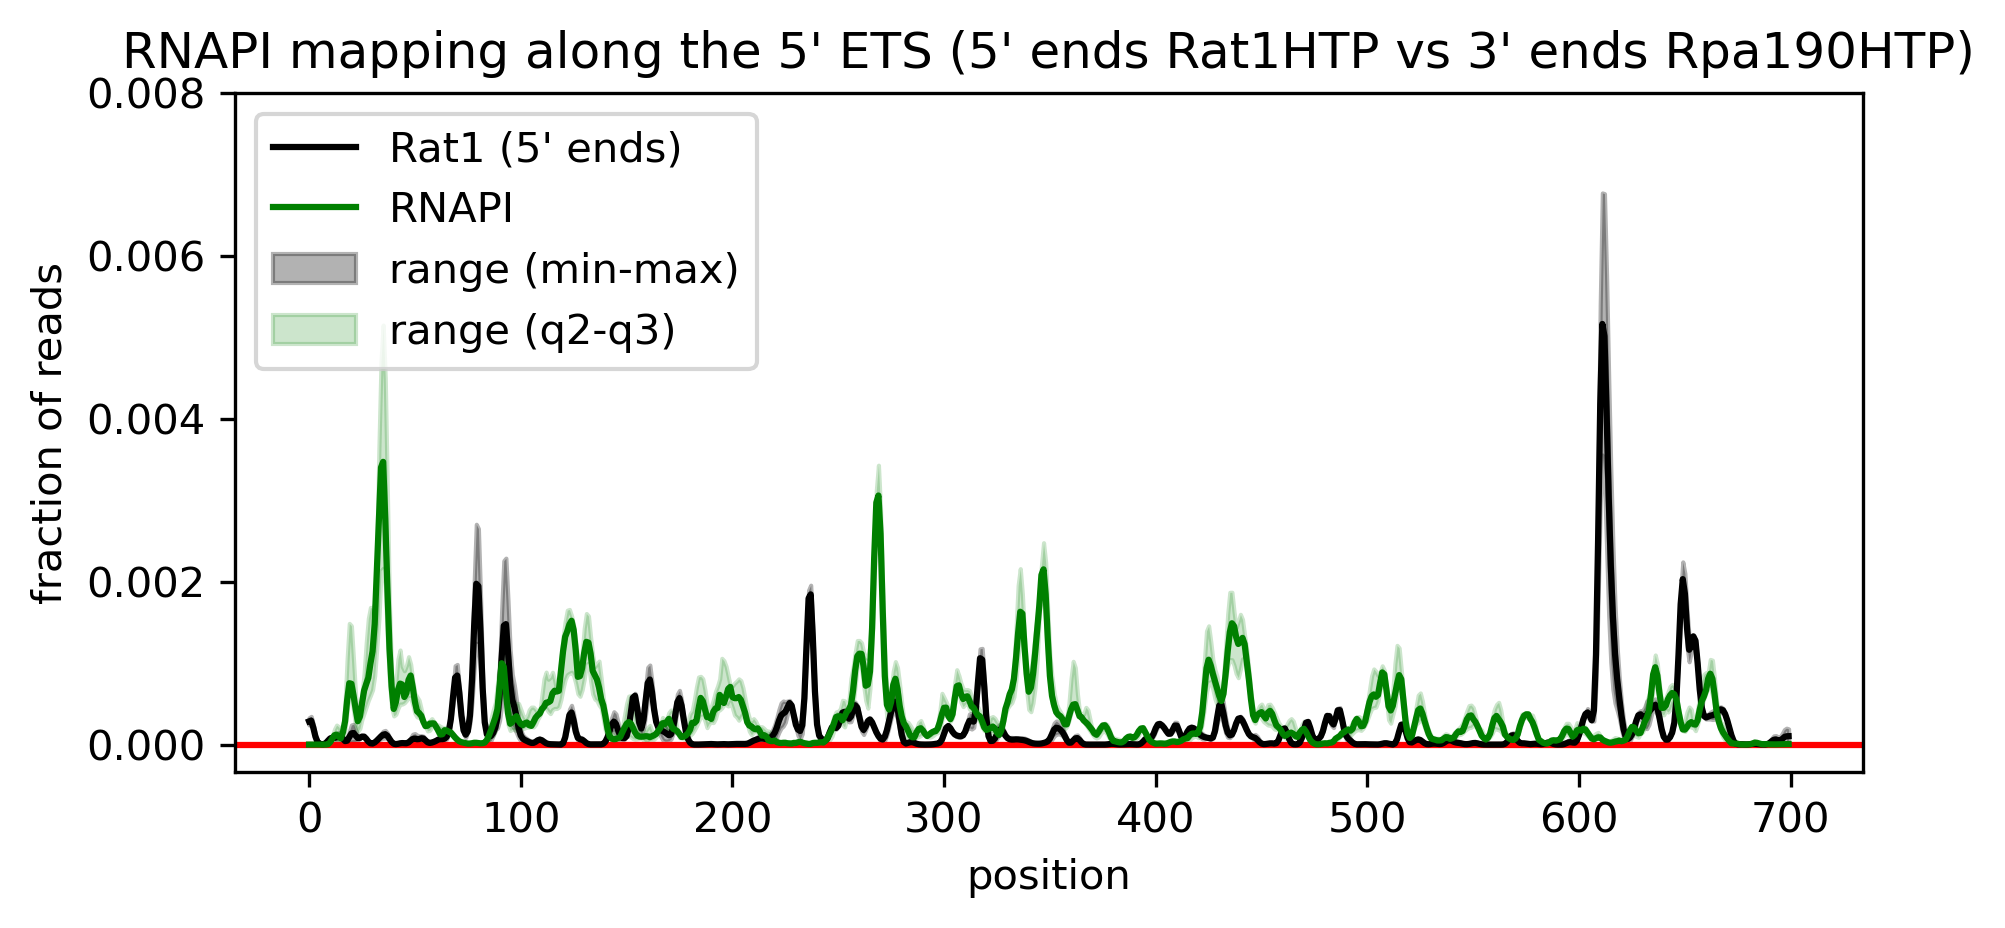

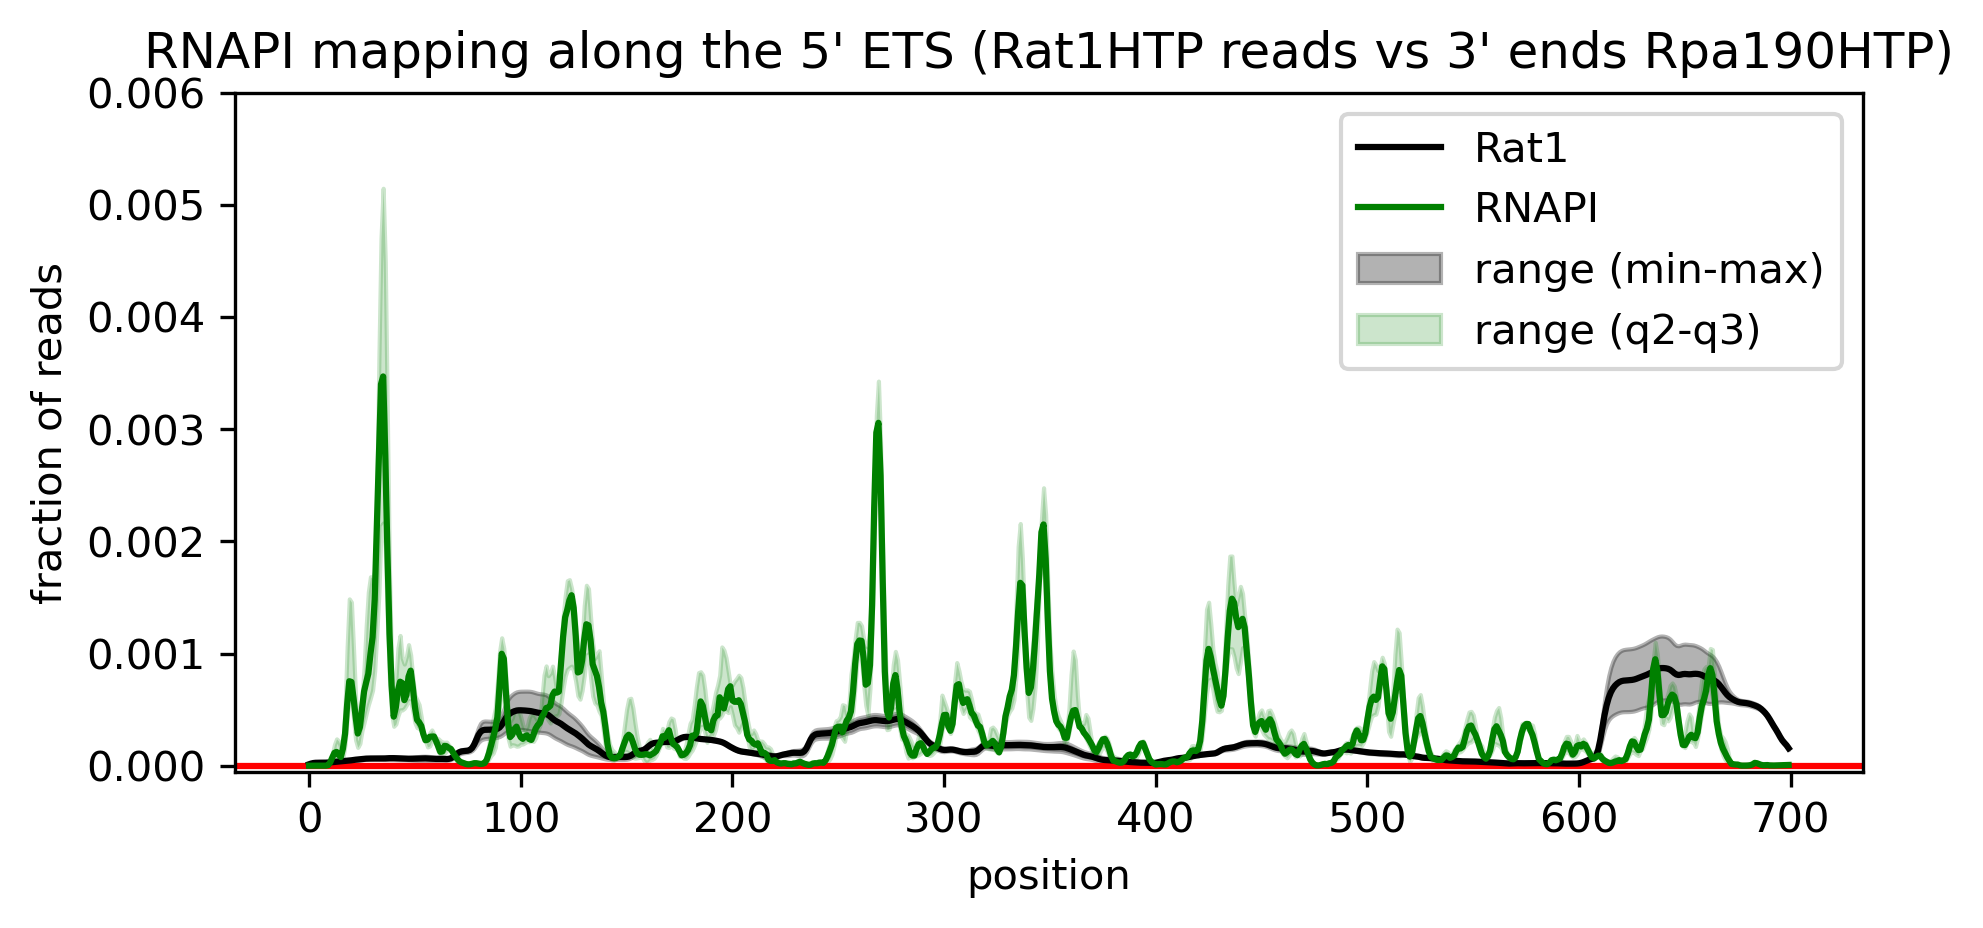

In [4]:
tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df14_Rat1_5end,figsize=(7,3),ref_label="RNAPI",label="Rat1 (5' ends)",
                           title="RNAPI mapping along the 5' ETS (5' ends Rat1HTP vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.008),
                           start=0+300, stop=700+300,
                           fname='Fig_4A.png')

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df13_Rat1_read,figsize=(7,3),ref_label="RNAPI",label="Rat1",
                           title="RNAPI mapping along the 5' ETS (Rat1HTP reads vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.006),
                           start=0+300, stop=700+300,
                           fname='Fig_S4A.png')

In [5]:
# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df17_Mtr4_read,figsize=(7,3),ref_label="RNAPI",label="Mtr4",
#                            title="RNAPI mapping along the 5' ETS (Mtr4HTP vs 3' ends Rpa190HTP)",
#                            dpi=300,offset=300, ylim=(None,0.006),
#                            start=0+300, stop=700+300,
#                            fname='Fig_S6B.png')

# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df19_Mtr4_3end,figsize=(7,3),ref_label="RNAPI",label="Mtr4 (3' ends)",
#                            title="RNAPI mapping along the 5' ETS (the 3' ends Mtr4HTP vs 3' ends Rpa190HTP)",
#                            dpi=300,offset=300, ylim=(None,0.014),
#                            start=0+300, stop=700+300,
#                            fname='Fig_6Bv1.png')

# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df20_Mtr4_polyA,figsize=(7,3),ref_label="RNAPI",label="Mtr4 (polyA)",
#                            title="RNAPI mapping along the 5' ETS (the polyA ends Mtr4HTP vs 3' ends Rpa190HTP)",
#                            dpi=300,offset=300, ylim=(None,0.009),
#                            start=0+300, stop=700+300,
#                            fname='Fig_6Bv2.png')

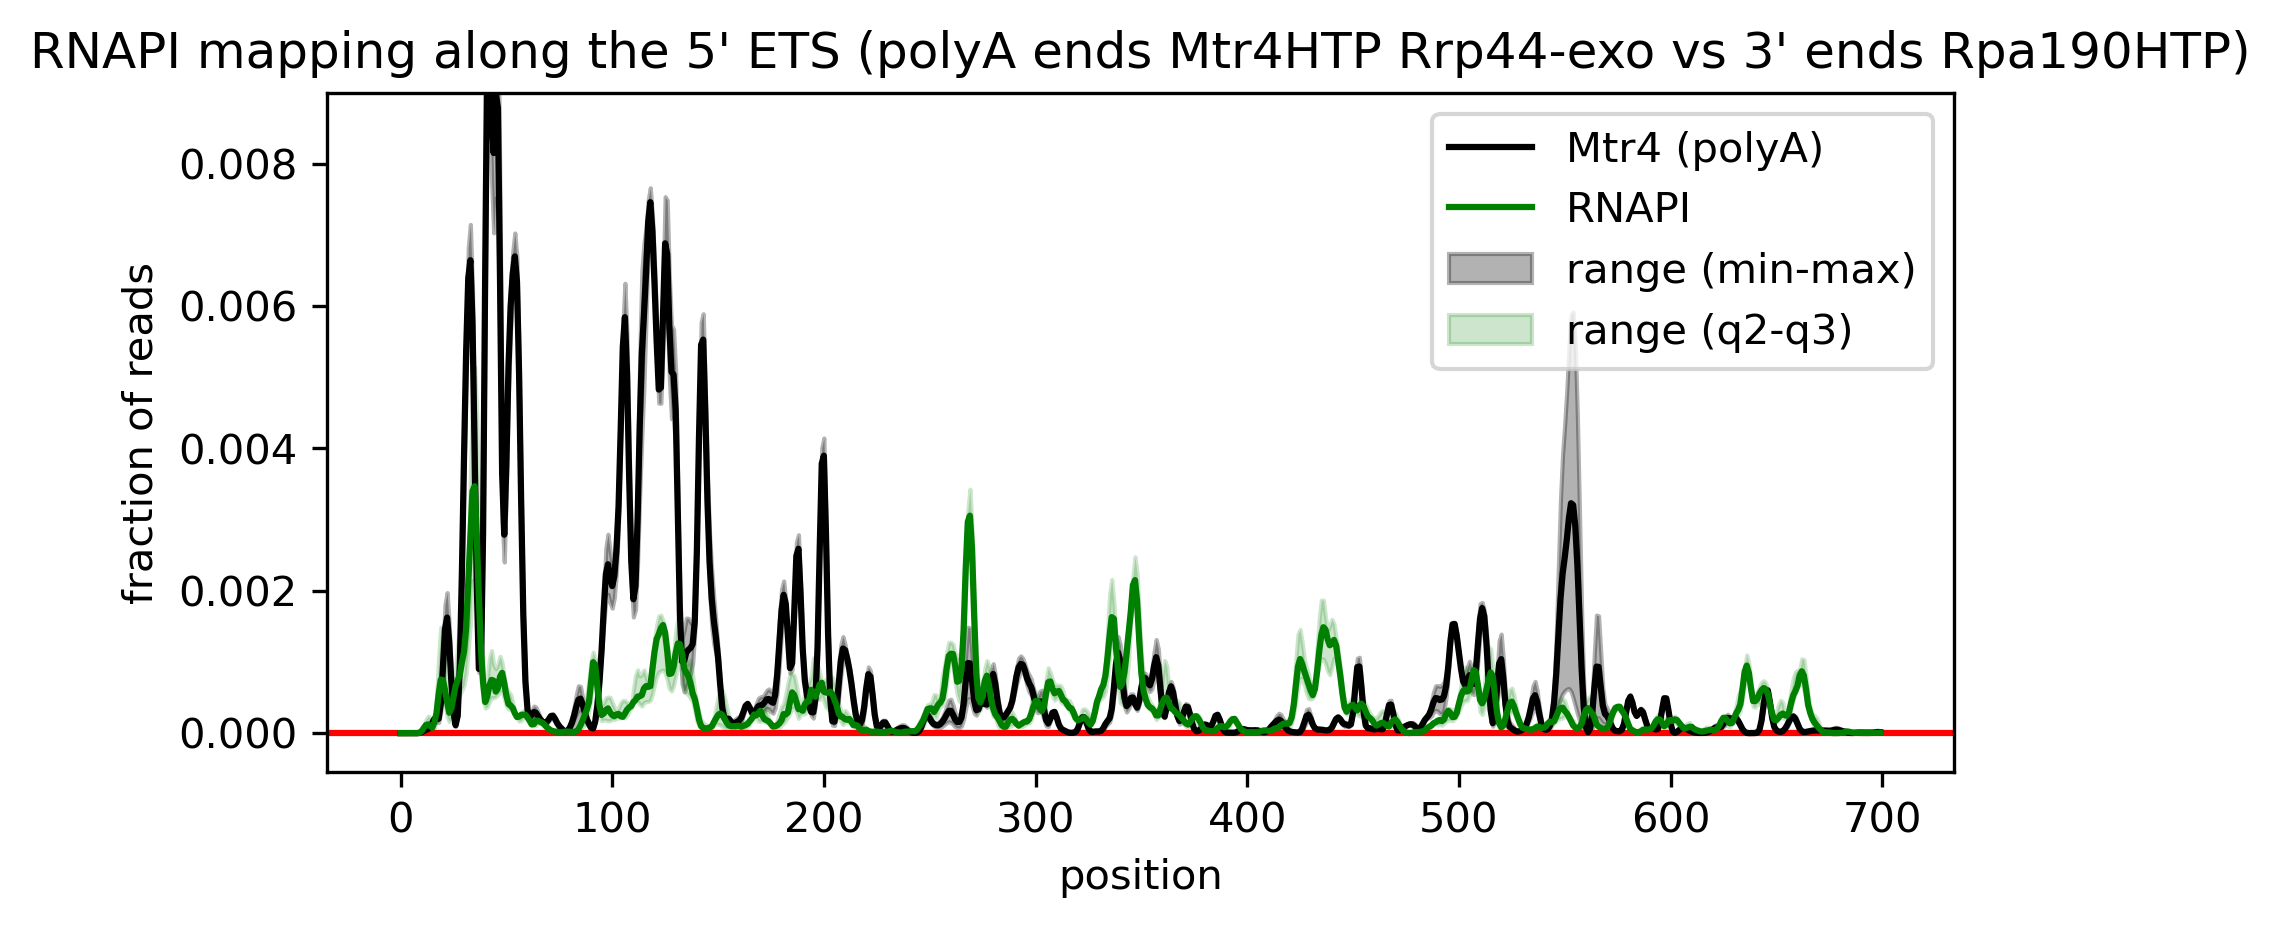

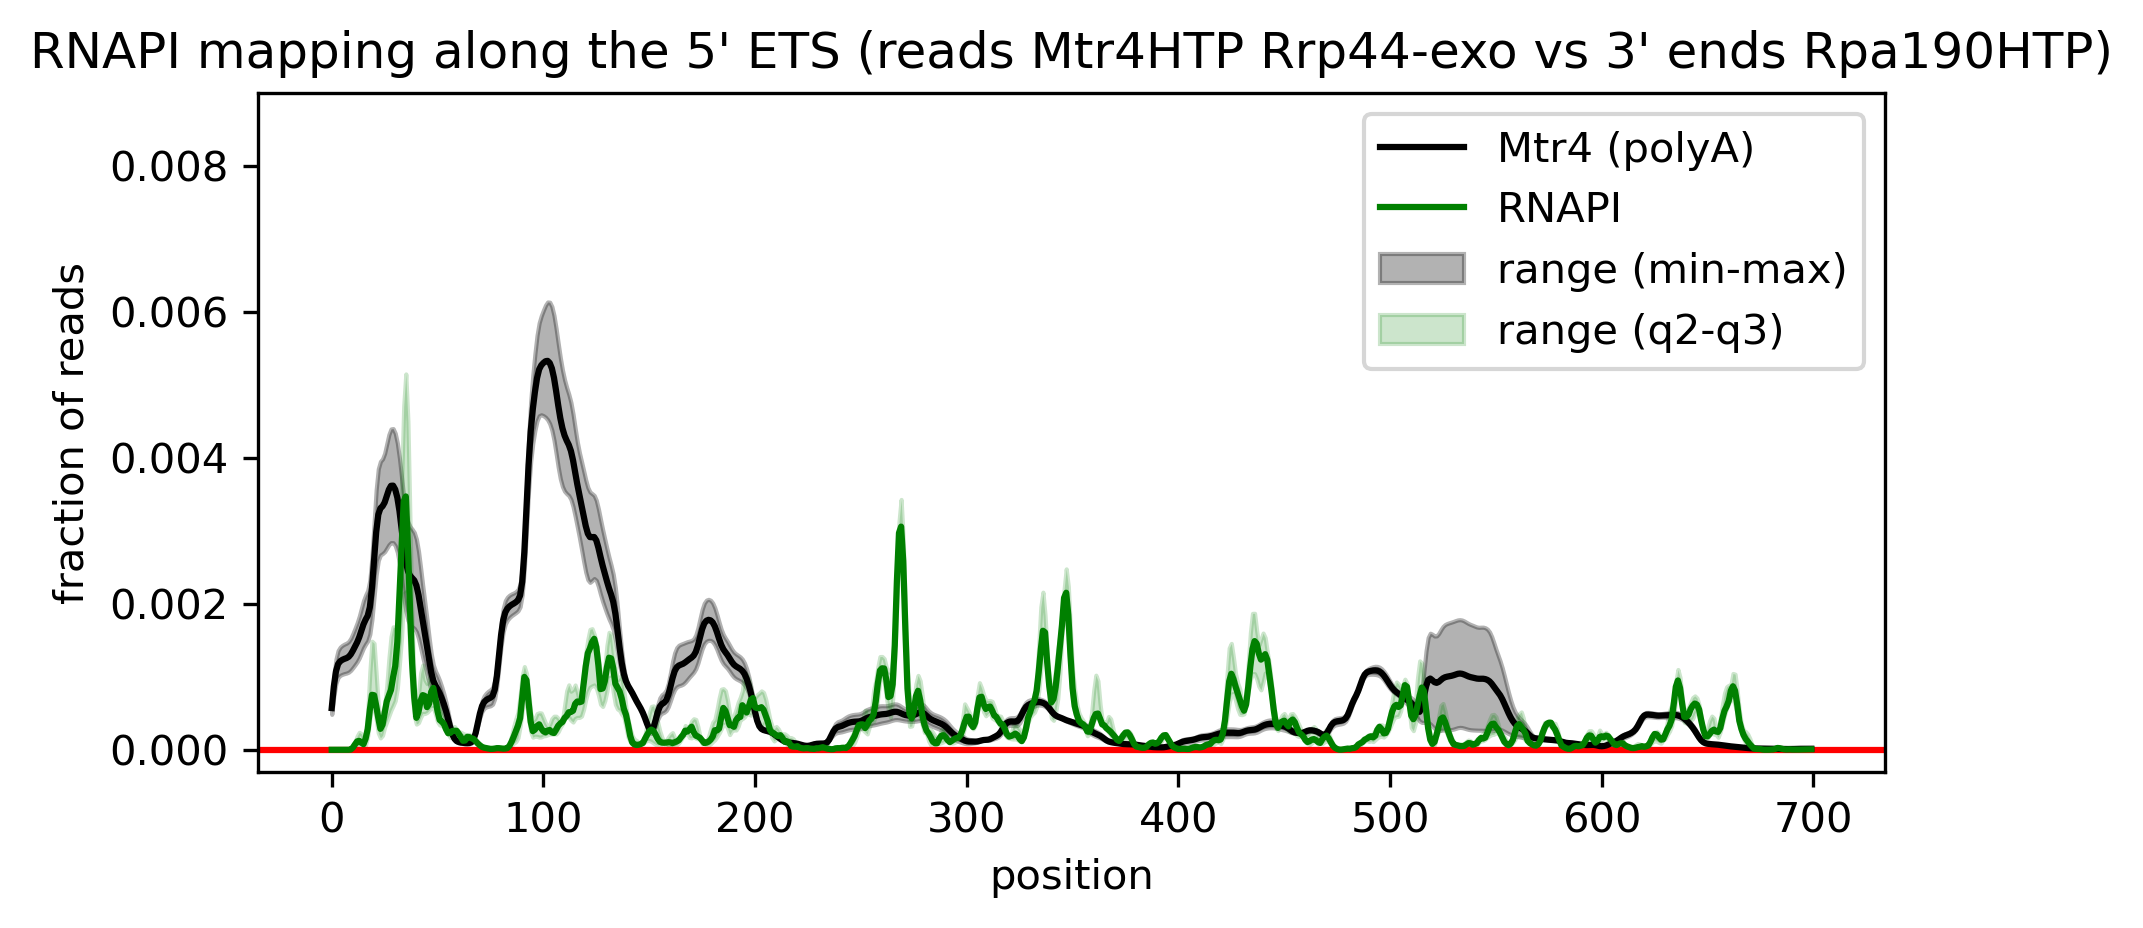

In [6]:
# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df21_Mtr4Rrp44exo_3end,figsize=(7,3),ref_label="RNAPI",label="Mtr4 (3' ends)",
#                            title="RNAPI mapping along the 5' ETS (3' ends Mtr4HTP Rrp44-exo vs 3' ends Rpa190HTP)",
#                            dpi=300,offset=300, ylim=(None,0.014),
#                            start=0+300, stop=700+300,
#                            fname='Fig_6Bv3.png')

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df22_Mtr4Rrp44exo_polyA,figsize=(7,3),ref_label="RNAPI",label="Mtr4 (polyA)",
                           title="RNAPI mapping along the 5' ETS (polyA ends Mtr4HTP Rrp44-exo vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.009),
                           start=0+300, stop=700+300,
                           fname='Fig_4C.png')

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df23_Mtr4Rrp44exo_read,figsize=(7,3),ref_label="RNAPI",label="Mtr4 (polyA)",
                           title="RNAPI mapping along the 5' ETS (reads Mtr4HTP Rrp44-exo vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.009),
                           start=0+300, stop=700+300,
                           fname='Fig_S4B.png')

In [7]:
peaks = tt.profiles.findPeaks(df11_Rpa190_3end['median'][:7200],order=45,window=80)
print(peaks)

df00_ref=pd.read_csv("../06_metadata/RDN37_reference_collapsed.csv", index_col=0)
loc_extr = argrelextrema(data=df00_ref.rolling(80,win_type="blackman",center=True).mean()['median'][:7200].to_numpy(), comparator=np.greater, order=50)[0]

print(len(peaks))
print(len(loc_extr))

[336, 425, 495, 568, 643, 737, 810, 947, 1094, 1169, 1372, 1502, 1561, 1724, 1827, 1902, 2049, 2123, 2249, 2347, 2500, 2598, 2686, 2789, 2908, 2977, 3074, 3258, 3339, 3472, 3640, 3795, 3903, 4018, 4103, 4282, 4363, 4497, 4578, 4650, 4769, 4910, 5041, 5102, 5157, 5237, 5416, 5686, 5752, 5873, 5938, 6107, 6224, 6323, 6495, 6594, 6697, 6796, 6910, 7027]
60
52


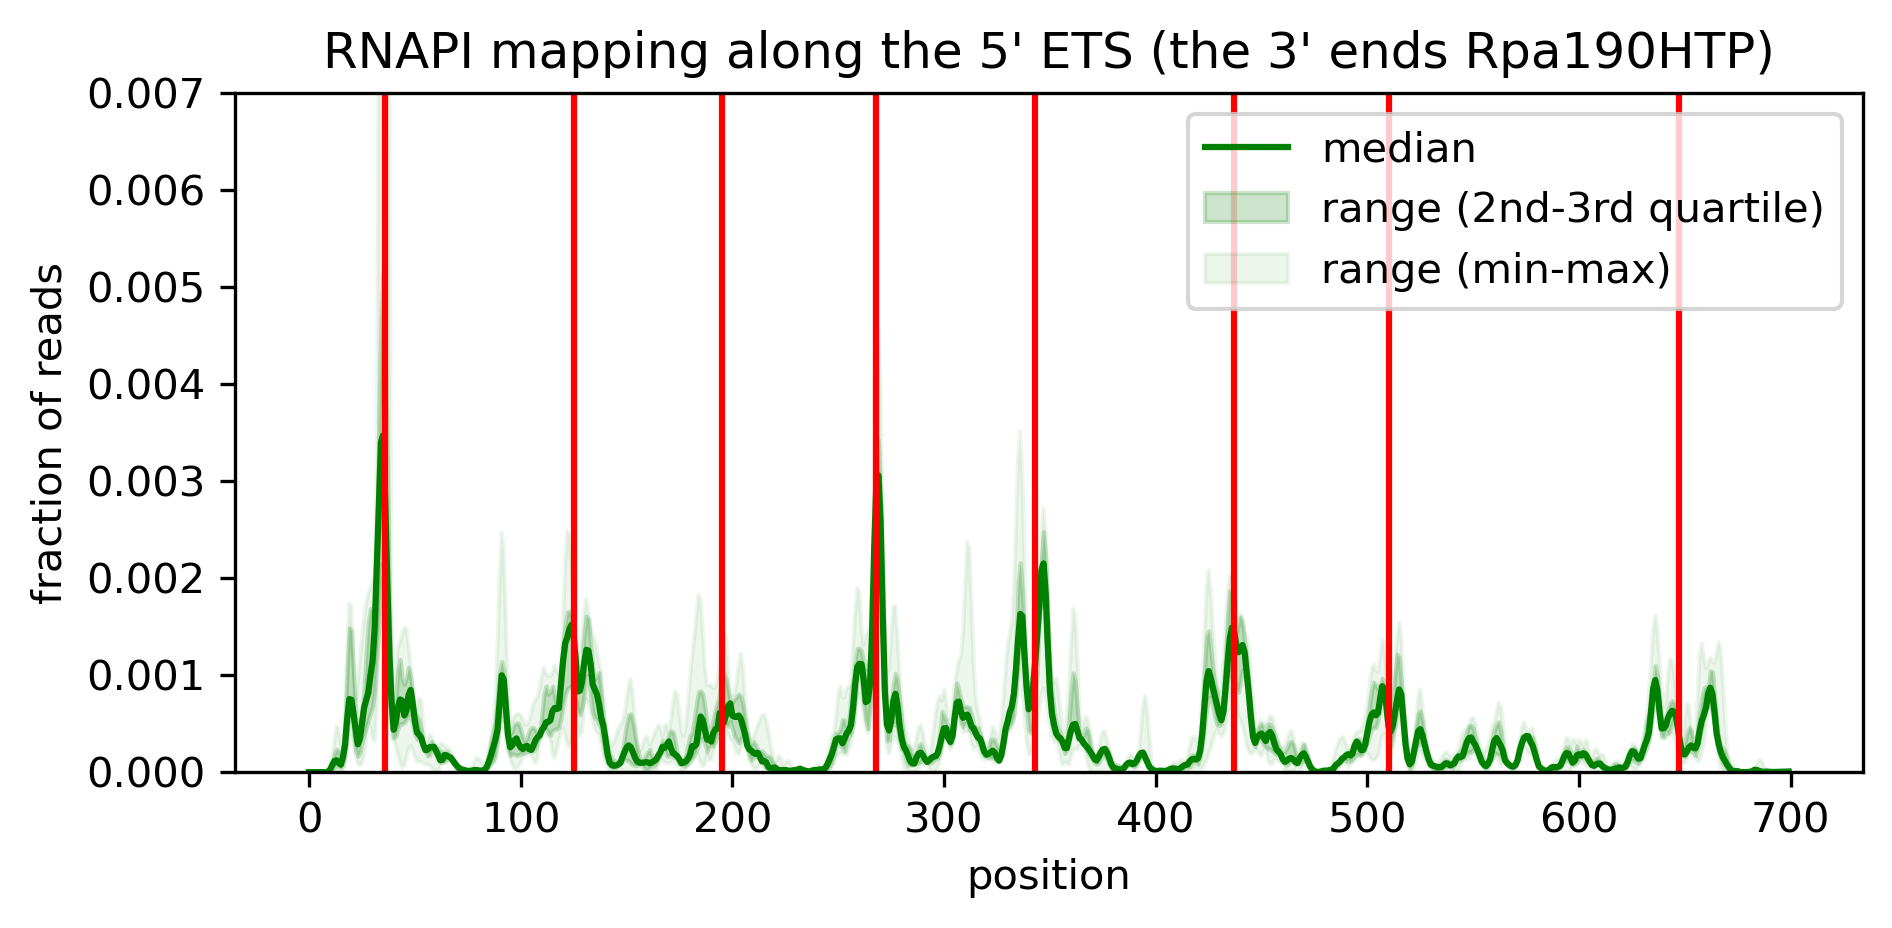

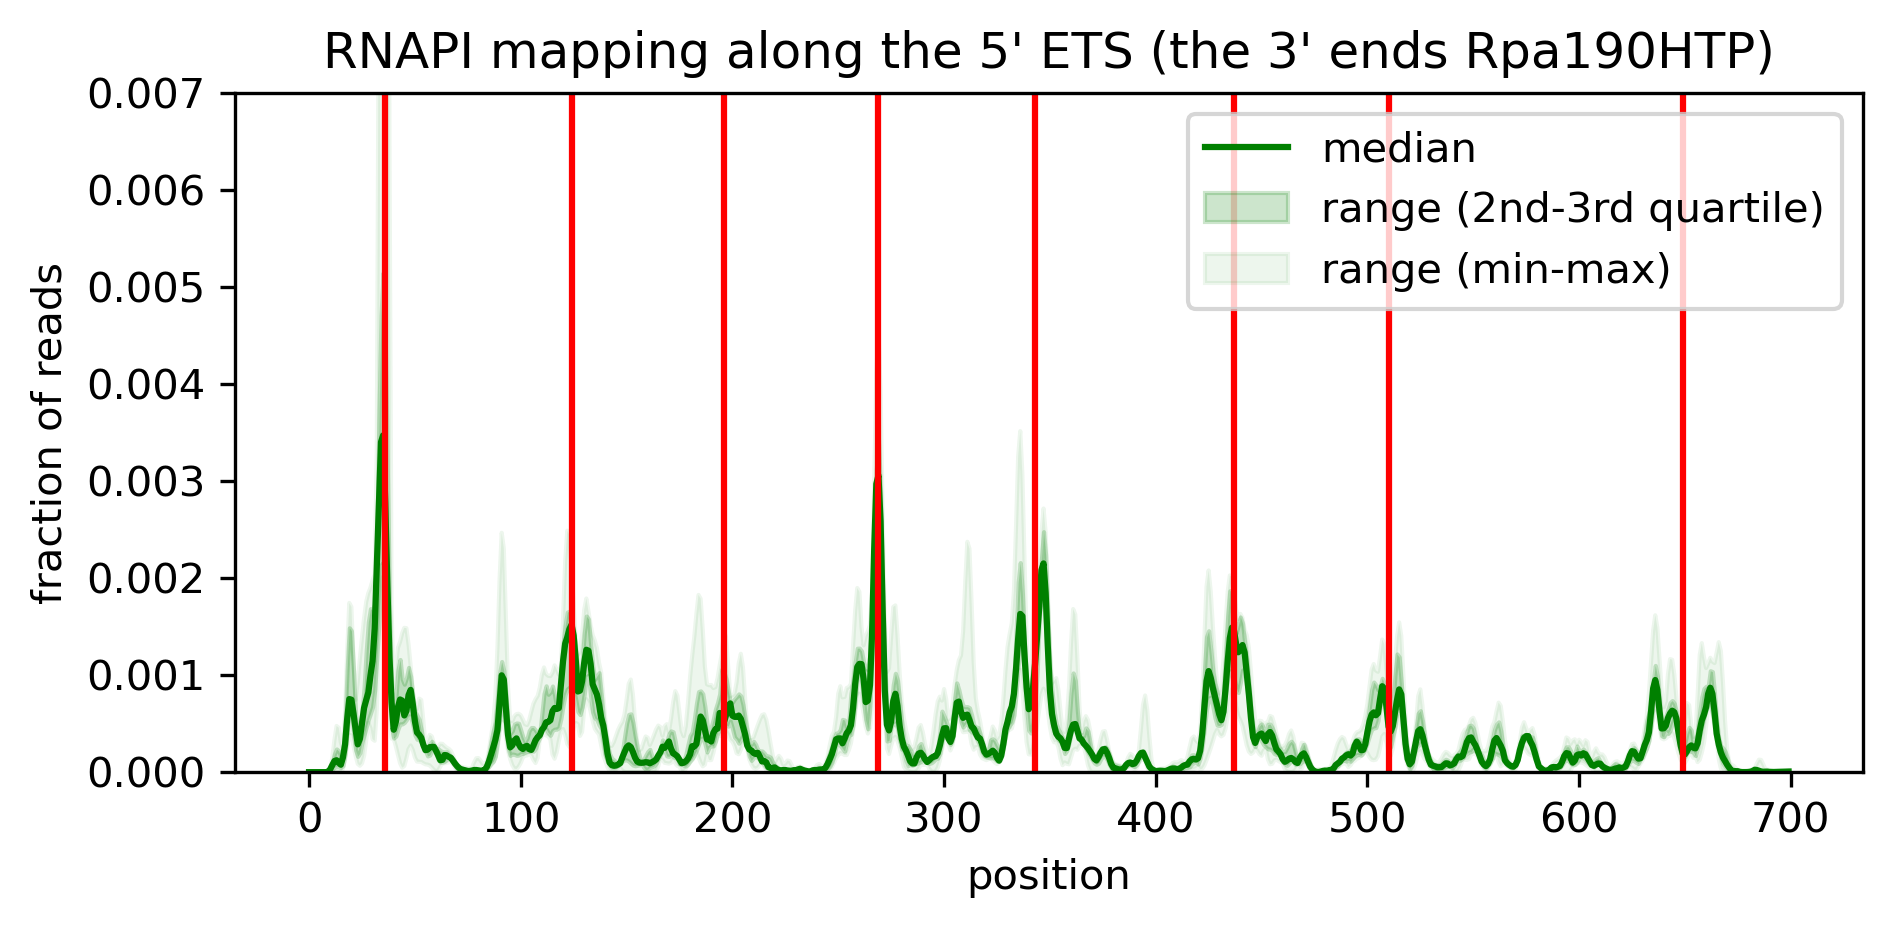

In [8]:
tt.plotting.plot_as_box_plot(df11_Rpa190_3end, title="RNAPI mapping along the 5' ETS (the 3' ends Rpa190HTP)",
                             dpi=300,ylim=(None,0.007), start=0+300, stop=700+300,
                             h_lines=[i-300 for i in peaks],offset=300,fname='Fig_S4C.png')

tt.plotting.plot_as_box_plot(df11_Rpa190_3end, title="RNAPI mapping along the 5' ETS (the 3' ends Rpa190HTP)",
                             dpi=300,ylim=(None,0.007), start=0+300, stop=700+300,
                             h_lines=[i-300 for i in loc_extr],offset=300,fname='Fig_S4D.png')

# 5' ETS

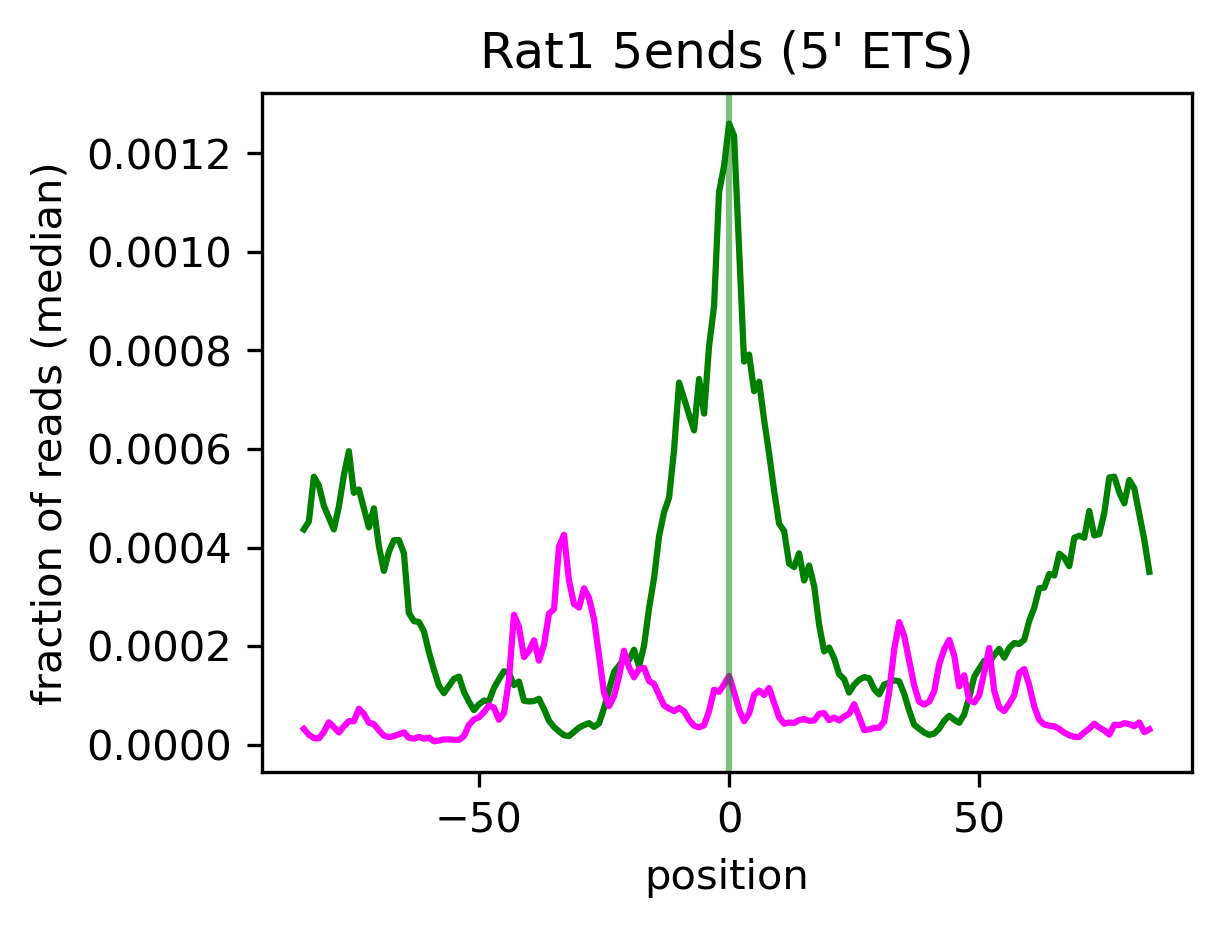

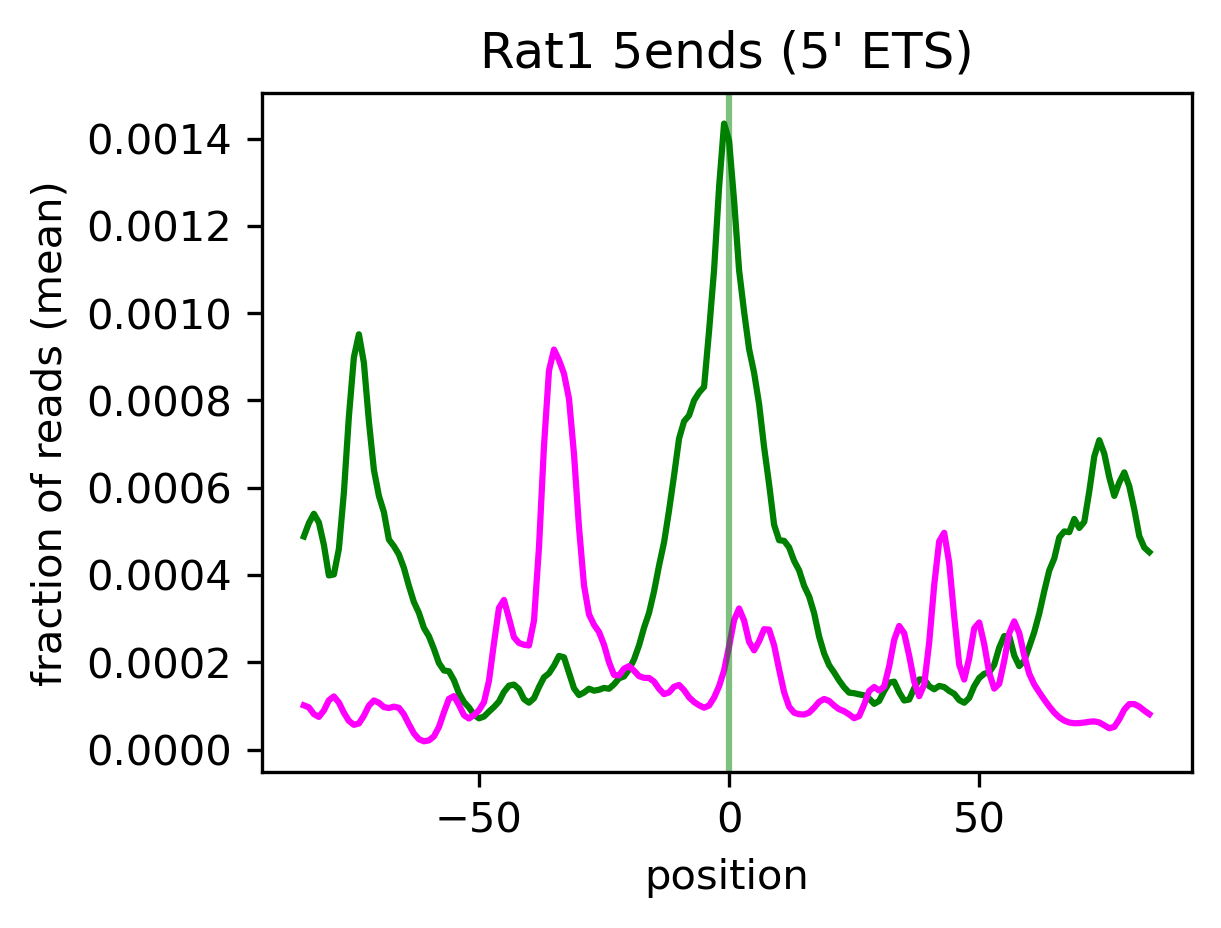

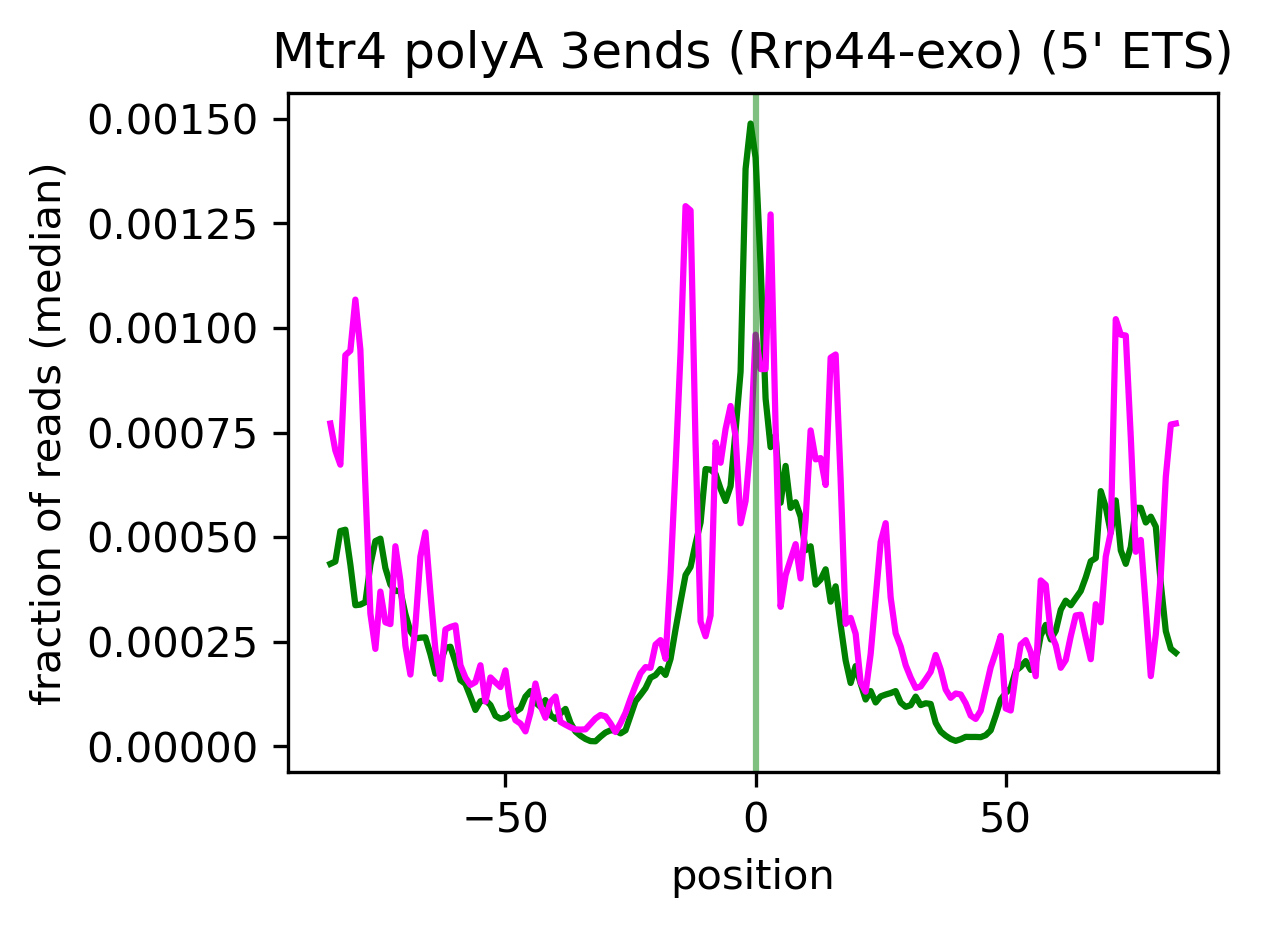

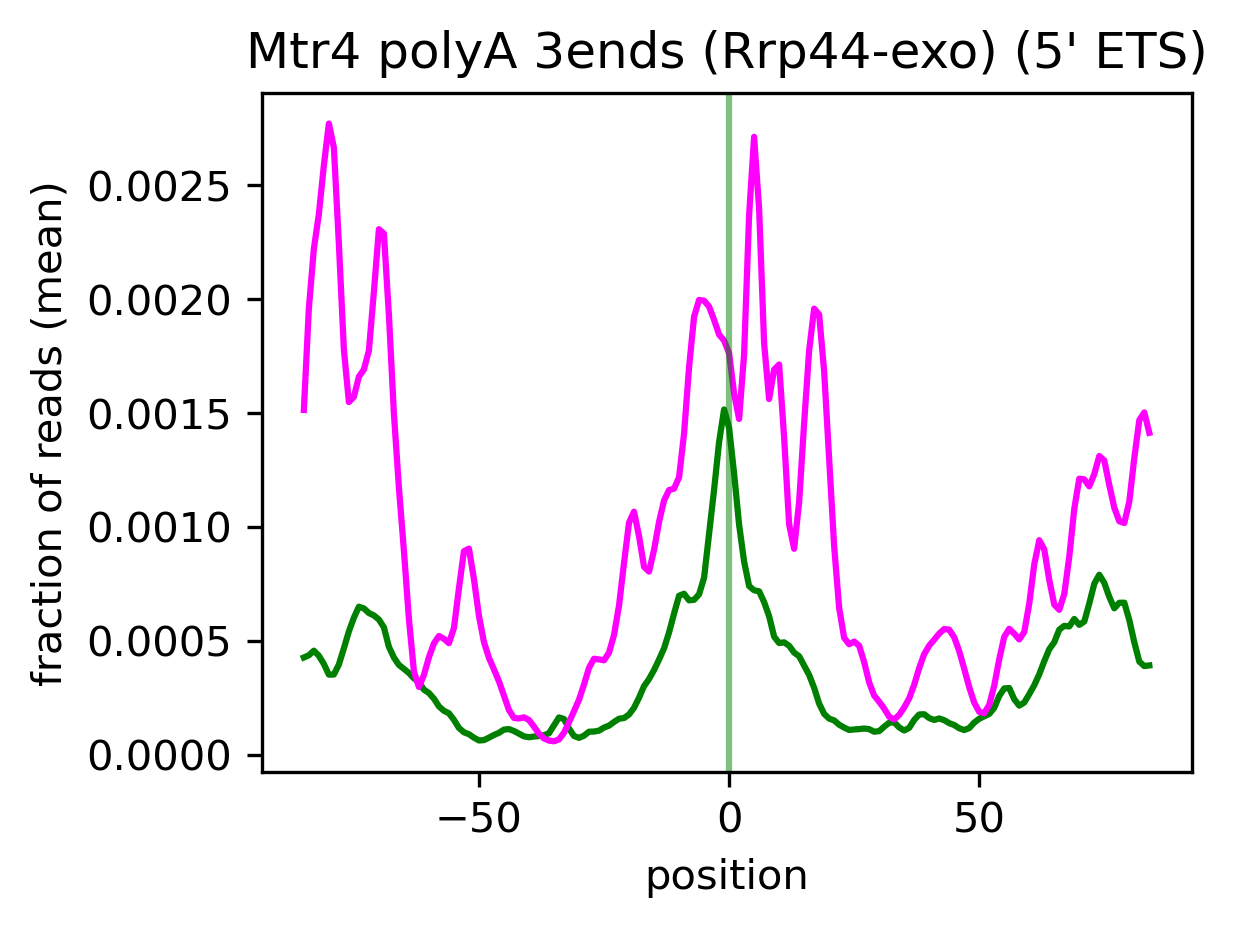

In [9]:
stop=1000
window = 85
elem=" (5' ETS)"

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4Bmedian.png",use='median')

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4B.png")

# tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df17_Mtr4_read, local_pos=peaks, dpi=300,
#                         title="Mtr4 read", start=None, stop=stop, window=window, figsize=(4,3),
#                         color1='green', color2="magenta", lc='green',fname="Fig_6D.png")

# tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df19_Mtr4_3end, local_pos=peaks, dpi=300,
#                         title="Mtr4 3' ends", start=None, stop=stop, window=window, figsize=(4,3),
#                         color1='green', color2="magenta", lc='green',fname="Fig_6D.png")

# tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df20_Mtr4_polyA, local_pos=peaks, dpi=300,
#                         title="Mtr4 polyA 3ends", start=None, stop=stop, window=100, figsize=(4,3),
#                         color1='green', color2="magenta", lc='green',fname="Fig_6D.png",use='median')

# tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df20_Mtr4_polyA, local_pos=peaks, dpi=300,
#                         title="Mtr4 polyA 3ends", start=None, stop=stop, window=window, figsize=(4,3),
#                         color1='green', color2="magenta", lc='green',fname="Fig_6D.png")

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4Dmedian.png",use='median')

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4D.png")

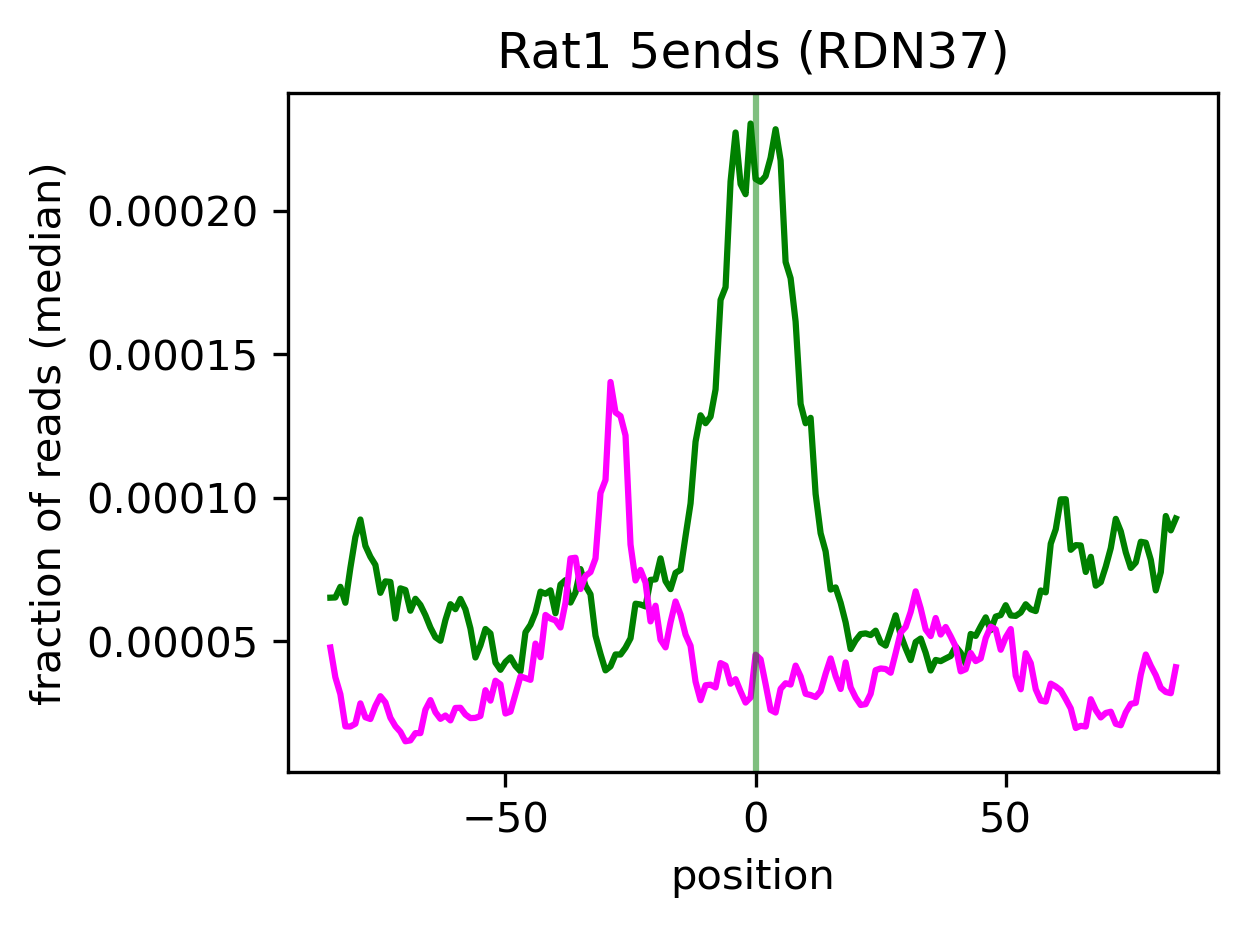

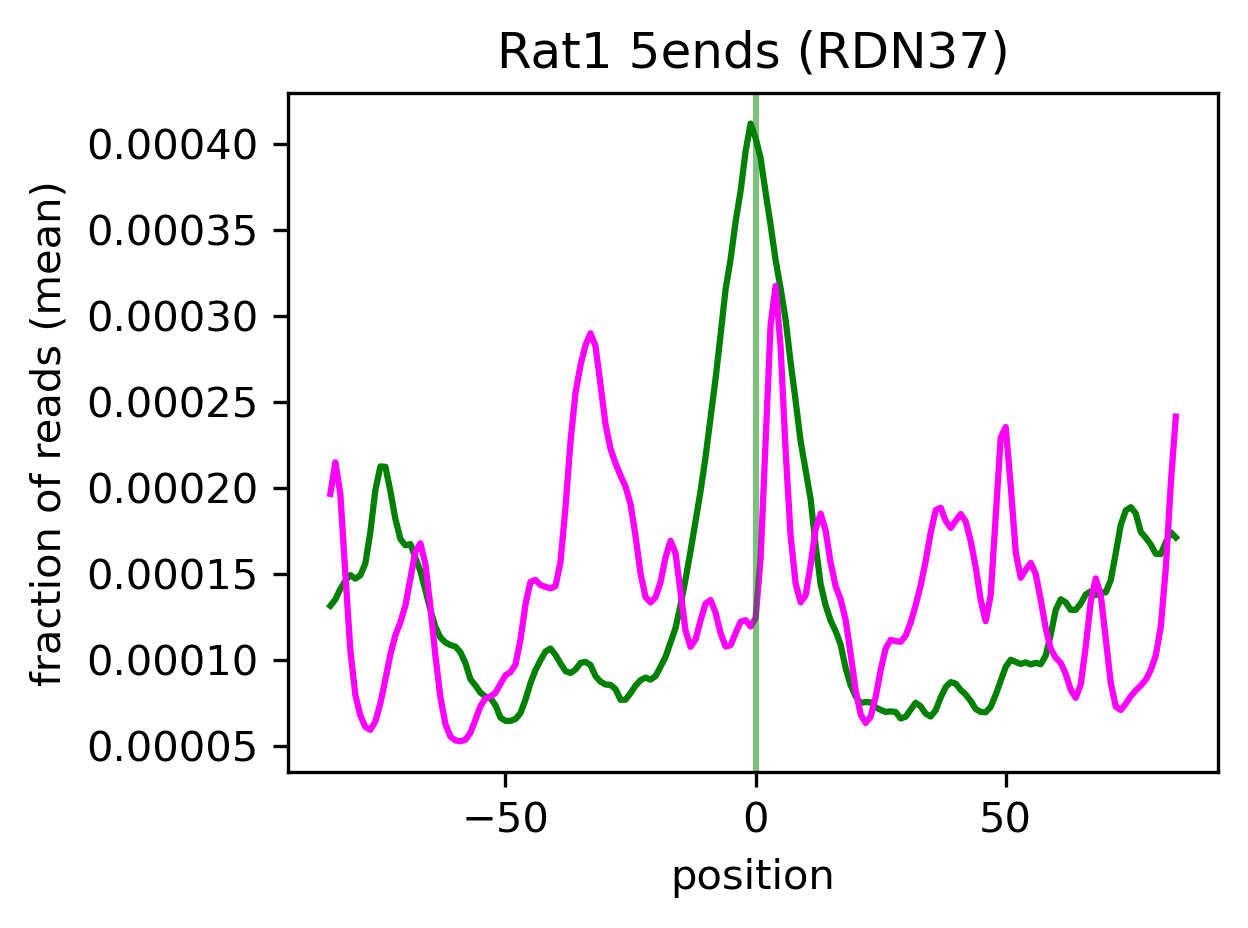

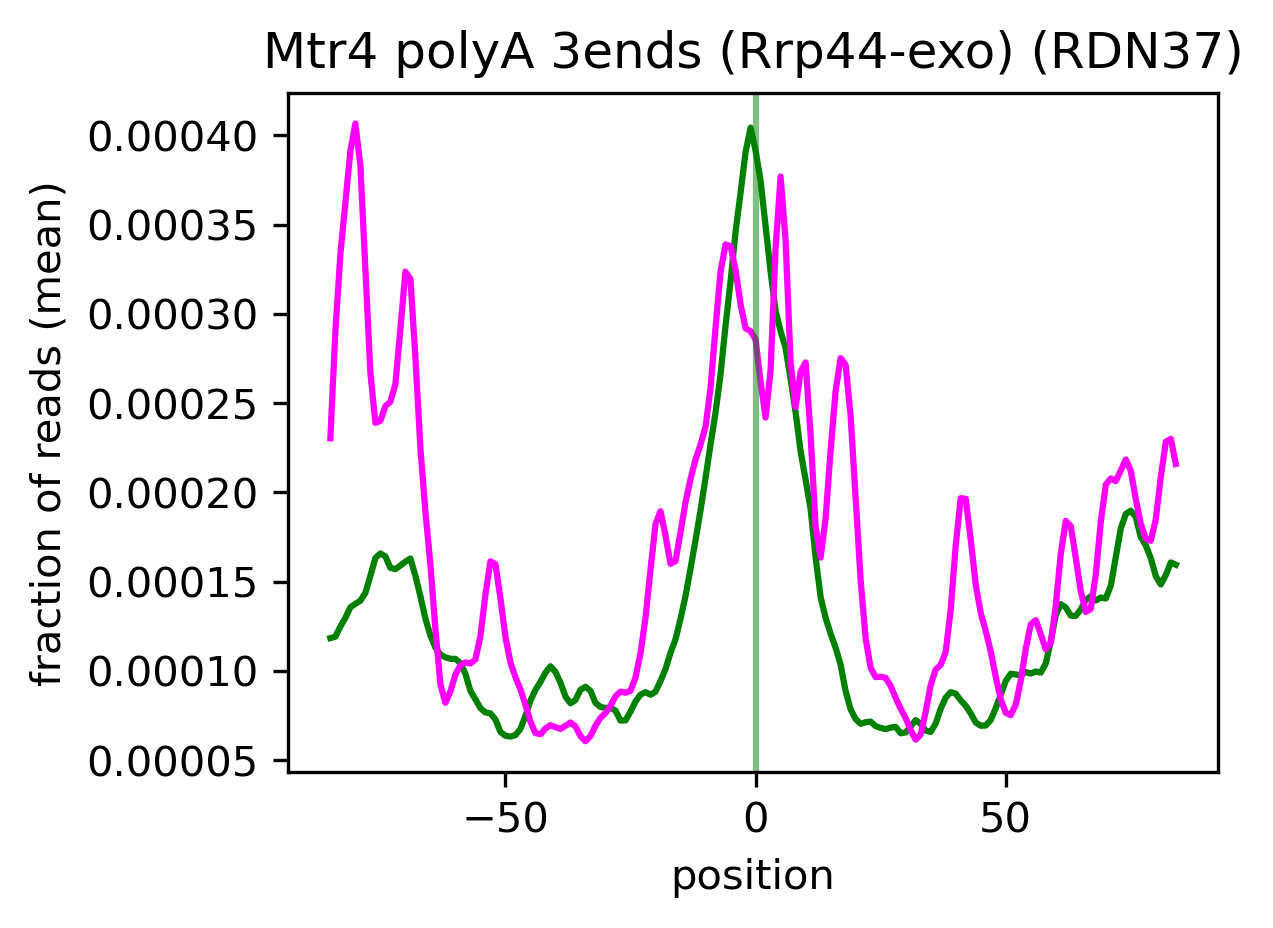

In [10]:
stop=7100
elem=" (RDN37)"

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4Bmedian_v2.png",use='median')

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4B_v2.png")

tt.plotting.plotCumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="magenta", lc='green',fname="Fig_4D_v2.png")

In [11]:
xxxx

NameError: name 'xxxx' is not defined

In [ ]:
def clusterDatasets(df, name="expID_bait_background_condition_replicate"):
    out_df = df.columns.to_series().str.split("_",expand=True)
    out_df.columns = [i for i in name.split("_")] #parse names
    out_df['dataset'] = out_df['bait']+"_"+out_df['background']+"_"+out_df['condition']
    out_df['bait_background'] = out_df['bait']+"_"+out_df['background']
    return out_df

rule_meta = {'RNAPI' : (["Rpa135HTP","Rpa190HTP"],["Rpa12dC"]),
        'Rpa12dC' : (['FPHRpa12'],["Rpa135HTP","Rpa190HTP","Rpa12dC"]),
        'RNAPI-Rpa12dC' : (["Rpa135HTP","Rpa190HTP","Rpa12dC"],['wt']),
        'RNAPII' : (["Rpo21HTP"],[]),
        'RNAPIII' : (["Rpc160HTP"],[]),
        'Rat1' : (["Rat1HTP"],[]),
        'surveillance' : (["Csl4HTP","Mtr4HTP","Rrp41HTP","Rrp44-exo-S1-HTP","Rrp44-exoHTP","Rrp44HTP","Rrp6HTP"],[]),
        "Nab2" : (["Nab2HTP"],[])
       }

rule = {'Rpa190HTP_wt' : (["Rpa190HTP"],["Rpa12dC",]),
               'Rpa135HTP_wt' : (["Rpa135HTP"],["Rpa12dC"]),
        'Rpa12dC' : (['FPHRpa12'],["Rpa135HTP","Rpa190HTP","Rpa12dC"]),
        'RNAPI-Rpa12dC' : (["Rpa135HTP","Rpa190HTP","Rpa12dC"],['wt']),
        'RNAPII' : (["Rpo21HTP"],[]),
        'RNAPIII' : (["Rpc160HTP"],[]),
        'Rat1' : (["Rat1HTP"],[]),
        'surveillance' : (["Csl4HTP","Mtr4HTP","Rrp41HTP","Rrp44-exo-S1-HTP","Rrp44-exoHTP","Rrp44HTP","Rrp6HTP"],[]),
        "Nab2" : (["Nab2HTP"],[])
       }

def metaDatasets(name,rule={}):
    out = []
    for k in rule.keys():
        let_in = rule[k][0]
        if rule[k][1]: let_out = rule[k][1]
        else: let_out = ['Wont find this string']
                    
        if any(i for i in let_in if i in name) and any(i for i in let_out if i not in name):
            out.append(k)
    if len(out)==1:
        return out[0]
    else:
        return 'unassigned'

In [ ]:
def getTotalCountBigWig(chrom={},data_path="", data_files=""):
    df_output = pd.DataFrame(index=chrom.keys())
    for name in strip_BigWig_names(data_files):
        df_temp = pd.DataFrame(index=chrom.keys())
        try:
            bw = pyBigWig.open(data_path+name+"_fwd.bw")
            for c in chrom.keys():
                df_temp.loc[c,'fwd']= bw.stats(c,type='sum',exact=True)[0]
        except:
            df_temp.loc[c,'fwd']= 0.0
        try:
            bw = pyBigWig.open(data_path+name+"_rev.bw")
            for c in chrom.keys():
                df_temp.loc[c,'rev']= bw.stats(c,type='sum',exact=True)[0]
        except:
            df_temp.loc[c,'rev']= 0.0
        
        df_temp = df_temp.fillna(0.0)
        df_output[name.replace("_polyA","").replace("_PROFILE_3end","").replace("_3end","").replace("_default","").replace("noUV_none","noUV")] = df_temp.sum(1)
    return df_output

df01_3ends = getTotalCountBigWig(chrom=chr_len.sort_index().to_dict(),data_path=pathDir,data_files=data_files_3end)
df02_polyA = getTotalCountBigWig(chrom=chr_len.sort_index().to_dict(),data_path=pathDir,data_files=data_files_polyA)

In [ ]:
df03_ratio = df02_polyA.sum() / df01_3ends.sum()
df03_ratio = df03_ratio.to_frame().T
# df03_ratio.sum().sort_values()

fig, ax1 = plt.subplots(figsize=(6,2), dpi=300)
plt.title('Fraction of polyA tails in different CRAC datasets')
ax1.set_xlabel('polyA fraction')
ax1.set_ylabel('number of reads')
#     ax1.set_ylim(ylim)
clusters = clusterDatasets(df03_ratio)
clusters['meta'] = clusters['dataset'].apply(metaDatasets,rule=rule)

for n,df in clusters.groupby('meta'):
    datasets = df.index.to_list()
    x = df03_ratio[datasets].sum()
    y = df01_3ends[datasets].sum()
    ax1.scatter(x,y,s=5,alpha=1,label=n, cmap="paired")
    
ax1.grid(axis='y', c='black', ls="dotted")

# texts = []
# for x, y, s in zip(df03_ratio.sum(), df01_3ends.sum(), clusters['dataset'].tolist()):
#     plt.text(x,y,s)

plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.01,10)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

In [ ]:
clusters['ratio'] = df03_ratio.T[0]

fraction = clusters.groupby('dataset').mean()['ratio']
labels = fraction.index.to_list()
sd = clusters.groupby('dataset').std()['ratio']
x = np.arange(len(fraction))
width = 0.3

fig, ax1 = plt.subplots(figsize=(len(x) / 4, 3), dpi=300)
plt.title('polyA fraction')
ax1.bar(x , fraction, width, yerr=sd)
ax1.set_yscale('log')
ax1.set_ylabel('Number of reads [log10]')
ax1.grid(axis='y', c='black', ls="dotted")
plt.xticks(x, labels, rotation=90)
plt.show()

In [ ]:
df04_ratio_chr12 = df02_polyA.loc['chrXII'] / df01_3ends.loc['chrXII']
df04_ratio_chr12 = df04_ratio_chr12.to_frame().T
# df03_ratio.sum().sort_values()

fig, ax1 = plt.subplots(figsize=(6,2), dpi=300)
plt.title('Fraction of polyA tails in different CRAC datasets - chrXII')
ax1.set_xlabel('polyA fraction')
ax1.set_ylabel('number of reads')
#     ax1.set_ylim(ylim)
clusters = clusterDatasets(df04_ratio_chr12)
clusters['meta'] = clusters['dataset'].apply(metaDatasets,rule=rule)

for n,df in clusters.groupby('meta'):
    datasets = df.index.to_list()
    x = df04_ratio_chr12[datasets].sum()
    y = df01_3ends[datasets].sum()
    ax1.scatter(x,y,s=5,alpha=1,label=n, cmap="paired")
    
ax1.grid(axis='y', c='black', ls="dotted")

# texts = []
# for x, y, s in zip(df03_ratio.sum(), df01_3ends.sum(), clusters['dataset'].tolist()):
#     plt.text(x,y,s)

plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.01,10)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

In [ ]:
clusters['ratio'] = df04_ratio_chr12.T

fraction = clusters.groupby('dataset').mean()['ratio']
labels = fraction.index.to_list()
sd = clusters.groupby('dataset').std()['ratio']
x = np.arange(len(fraction))
width = 0.3

fig, ax1 = plt.subplots(figsize=(len(x) / 4, 3), dpi=300)
plt.title('polyA fraction')
ax1.bar(x , fraction, width, yerr=sd)
ax1.set_yscale('log')
ax1.set_ylabel('Number of reads [log10]')
ax1.grid(axis='y', c='black', ls="dotted")
plt.xticks(x, labels, rotation=90)
plt.show()